In [2]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


Добавим тестовую заметку в версию. Это будет 1.0

Теперь добавим вторую заметку. 2.0

In [3]:
pip install tensorflow_decision_forests


Note: you may need to restart the kernel to use updated packages.


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import tensorflow as tf
import tensorflow_decision_forests as tfdf
# machine learning libraries
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder

# remove warnings
import warnings
warnings.filterwarnings('ignore')

# full columns display
pd.options.display.max_columns = None
# full rows display
pd.options.display.max_rows = None

In [6]:
# Загружаем данные
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

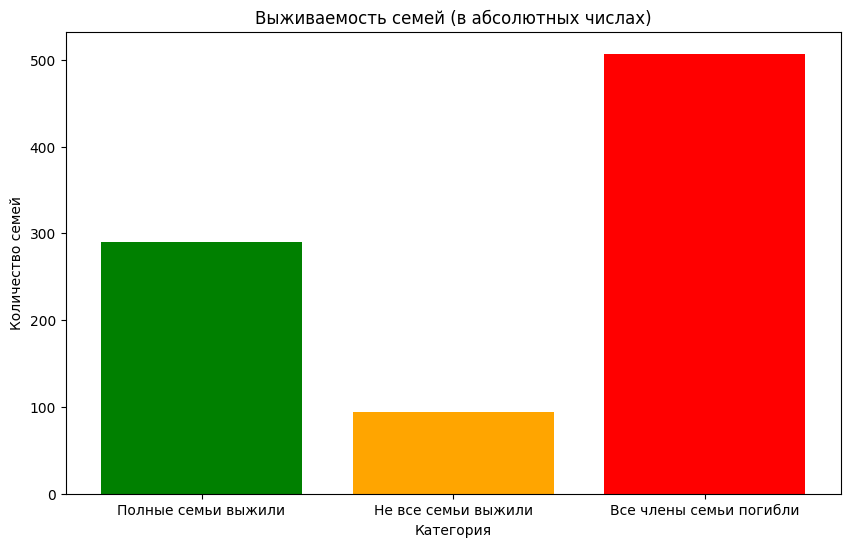

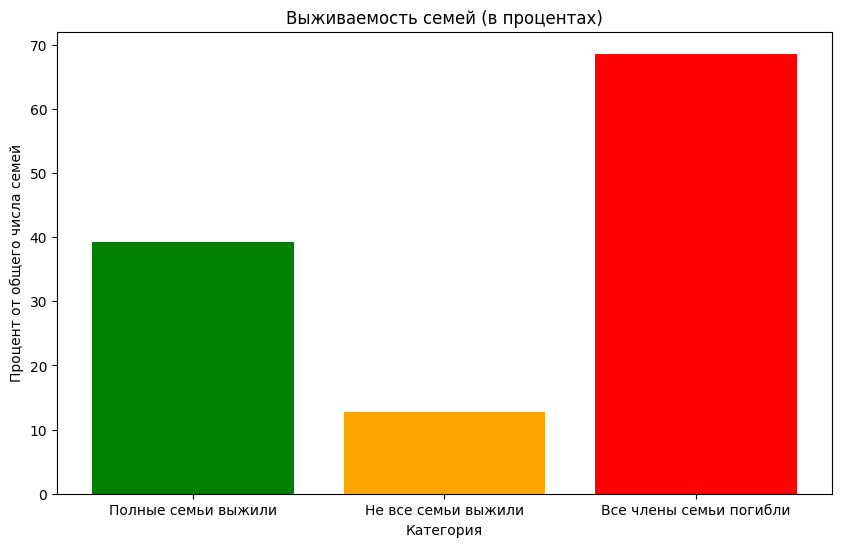

Всего семей: 739
Полные семьи выжили: 290 (39.24%)
Не все семьи выжили: 94 (12.72%)
Все члены семьи погибли: 507 (68.61%)
                                                Name  FamilyCount  \
0                            Braund, Mr. Owen Harris            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...            1   
2                             Heikkinen, Miss. Laina            1   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)            2   
4                           Allen, Mr. William Henry            1   

   FamilyAllSurvived  FamilyAllPerished  FamilyIncompleteSurvival  
0                  0                  1                         0  
1                  1                  0                         0  
2                  1                  0                         0  
3                  0                  0                         1  
4                  0                  1                         0  


In [9]:
def analyze_family_survival_with_visualization(df):
    df = df.copy()

    # Удаляем пассажиров без данных о выживаемости
    if 'Survived' in df.columns:
        df = df.dropna(subset=['Survived'])

    # Извлекаем фамилию
    df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0].strip())
    
    # Создаём идентификатор семьи (фамилия + билет)
    df['FamilyID'] = df['LastName'] + '_' + df['Ticket'].astype(str)
    
    # Считаем общее количество членов семьи
    family_counts = df['FamilyID'].value_counts()
    df['FamilyCount'] = df['FamilyID'].map(family_counts)
    
    # Проверяем выживаемость всей семьи
    family_all_survived = df.groupby('FamilyID')['Survived'].apply(lambda x: int(all(x)))
    family_all_perished = df.groupby('FamilyID')['Survived'].apply(lambda x: int(not any(x)))
    df['FamilyAllSurvived'] = df['FamilyID'].map(family_all_survived)
    df['FamilyAllPerished'] = df['FamilyID'].map(family_all_perished)

    # Вычисляем "Не все семьи выжили": хотя бы один выжил, но не все
    family_incomplete_survival = df.groupby('FamilyID')['Survived'].apply(
        lambda x: int(any(x) and not all(x))
    )
    df['FamilyIncompleteSurvival'] = df['FamilyID'].map(family_incomplete_survival)

    # Считаем категории
    total_families = df['FamilyID'].nunique()
    full_family_survivals = df['FamilyAllSurvived'].sum()  # Полные семьи выжили
    full_family_perished = df['FamilyAllPerished'].sum()  # Все члены семьи погибли
    incomplete_family_survivals = df['FamilyIncompleteSurvival'].sum()  # Только часть семьи выжила

    # Вычисляем проценты
    full_family_survivals_pct = (full_family_survivals / total_families) * 100
    incomplete_family_survivals_pct = (incomplete_family_survivals / total_families) * 100
    full_family_perished_pct = (full_family_perished / total_families) * 100

    # Визуализация
    plt.figure(figsize=(10, 6))
    plt.bar(
        ['Полные семьи выжили', 'Не все семьи выжили', 'Все члены семьи погибли'], 
        [full_family_survivals, incomplete_family_survivals, full_family_perished], 
        color=['green', 'orange', 'red']
    )
    plt.title('Выживаемость семей (в абсолютных числах)')
    plt.ylabel('Количество семей')
    plt.xlabel('Категория')
    plt.show()

    # Визуализация в процентах
    plt.figure(figsize=(10, 6))
    plt.bar(
        ['Полные семьи выжили', 'Не все семьи выжили', 'Все члены семьи погибли'], 
        [full_family_survivals_pct, incomplete_family_survivals_pct, full_family_perished_pct], 
        color=['green', 'orange', 'red']
    )
    plt.title('Выживаемость семей (в процентах)')
    plt.ylabel('Процент от общего числа семей')
    plt.xlabel('Категория')
    plt.show()

    # Вывод статистики
    print(f"Всего семей: {total_families}")
    print(f"Полные семьи выжили: {full_family_survivals} ({full_family_survivals_pct:.2f}%)")
    print(f"Не все семьи выжили: {incomplete_family_survivals} ({incomplete_family_survivals_pct:.2f}%)")
    print(f"Все члены семьи погибли: {full_family_perished} ({full_family_perished_pct:.2f}%)")

    # Возвращаем обработанный DataFrame
    return df

# Применяем функцию к тренировочным данным
train_data = analyze_family_survival_with_visualization(train_data)

# Проверяем результат
print(train_data[['Name', 'FamilyCount', 'FamilyAllSurvived', 'FamilyAllPerished', 'FamilyIncompleteSurvival']].head())


In [10]:
def add_family_survival_features(df):
    df = df.copy()

    # Извлекаем фамилию
    df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0].strip())
    
    # Создаём идентификатор семьи
    df['FamilyID'] = df['LastName'] + '_' + df['Ticket'].astype(str)
    
    # Считаем количество членов семьи
    family_counts = df['FamilyID'].value_counts()
    df['FamilyCount'] = df['FamilyID'].map(family_counts)
    
    # Если в данных есть колонка 'Survived', добавляем информацию о других членах семьи
    if 'Survived' in df.columns:
        # Количество выживших в семье
        family_survivors = df.groupby('FamilyID')['Survived'].sum()
        df['FamilySurvivors'] = df['FamilyID'].map(family_survivors)

        # Количество погибших в семье
        family_perished = df.groupby('FamilyID')['Survived'].apply(lambda x: len(x) - x.sum())
        df['FamilyPerished'] = df['FamilyID'].map(family_perished)
        
        # Признаки для модели
        df['FamilySurvivorFlag'] = (df['FamilySurvivors'] > 0).astype(int)  # Если хотя бы один выжил
        df['FamilyPerishedFlag'] = (df['FamilyPerished'] == df['FamilyCount']).astype(int)  # Все погибли

    # Для одиночек (FamilyCount == 1) устанавливаем особые значения
    df.loc[df['FamilyCount'] == 1, ['FamilySurvivors', 'FamilyPerished', 
                                    'FamilySurvivorFlag', 'FamilyPerishedFlag']] = 0

    return df

# Применяем функцию к тренировочным и тестовым данным
train_data = add_family_survival_features(train_data)
test_data = add_family_survival_features(test_data)

# Проверяем результат
print(train_data[['Name', 'FamilyCount', 'FamilySurvivors', 'FamilyPerished', 
                  'FamilySurvivorFlag', 'FamilyPerishedFlag']].head())


                                                Name  FamilyCount  \
0                            Braund, Mr. Owen Harris            1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...            1   
2                             Heikkinen, Miss. Laina            1   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)            2   
4                           Allen, Mr. William Henry            1   

   FamilySurvivors  FamilyPerished  FamilySurvivorFlag  FamilyPerishedFlag  
0                0               0                   0                   0  
1                0               0                   0                   0  
2                0               0                   0                   0  
3                1               1                   1                   0  
4                0               0                   0                   0  


In [11]:
input_features = [
    'Pclass', 'Sex', 'Age', 'FamilySurvivorFlag', 'FamilyPerishedFlag', 'FamilySurvivors', ...
]


In [12]:


# Загружаем данные
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Функция для предобработки
def preprocess(df):
    df = df.copy()
    
    # Удаляем ID
    if 'PassengerId' in df.columns:
        df = df.drop(columns=['PassengerId'])
    
    # Нормализация имени
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    
    df["Name"] = df["Name"].apply(normalize_name)
    
    # Преобразуем пол в числа
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    
    # Создаем колонку "FamilySize"
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df = df.drop(columns=["SibSp", "Parch"])  # Удаляем исходные колонки
    
    # Обработка номера билета
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    df = df.drop(columns=["Ticket"])  # Удаляем оригинальную колонку
    
    # Расчет "FarePerPerson" и округление
    df["FarePerPerson"] = (df["Fare"] / df["FamilySize"]).round(2)
    
    # Преобразование Embarked в числа
    embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
    df["Embarked"] = df["Embarked"].map(embarked_mapping)
    
    return df

# Добавляем признаки о семье
def add_family_survival_features(df):
    df = df.copy()

    # Извлекаем фамилию
    df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0].strip())
    
    # Создаём идентификатор семьи
    df['FamilyID'] = df['LastName'] + '_' + df['Ticket_item'].astype(str)
    
    # Считаем количество членов семьи
    family_counts = df['FamilyID'].value_counts()
    df['FamilyCount'] = df['FamilyID'].map(family_counts)
    
    # Если в данных есть колонка 'Survived', добавляем информацию о других членах семьи
    if 'Survived' in df.columns:
        # Количество выживших в семье
        family_survivors = df.groupby('FamilyID')['Survived'].sum()
        df['FamilySurvivors'] = df['FamilyID'].map(family_survivors)

        # Количество погибших в семье
        family_perished = df.groupby('FamilyID')['Survived'].apply(lambda x: len(x) - x.sum())
        df['FamilyPerished'] = df['FamilyID'].map(family_perished)
        
        # Признаки для модели
        df['FamilySurvivorFlag'] = (df['FamilySurvivors'] > 0).astype(int)  # Если хотя бы один выжил
        df['FamilyPerishedFlag'] = (df['FamilyPerished'] == df['FamilyCount']).astype(int)  # Все погибли

    # Для одиночек (FamilyCount == 1) устанавливаем особые значения
    df.loc[df['FamilyCount'] == 1, ['FamilySurvivors', 'FamilyPerished', 
                                    'FamilySurvivorFlag', 'FamilyPerishedFlag']] = 0

    return df

# Применяем предобработку и добавление признаков
train_data = preprocess(train_data)
train_data = add_family_survival_features(train_data)

# Создаём список входных признаков
input_features = list(train_data.columns)
input_features.remove("Survived")  # Убираем целевую переменную
#input_features.remove("FarePerPerson")  # Убираем текстовые данные, если они не нужны

# Создаём TensorFlow Dataset
def tokenize_names(features, labels=None):
    """Токенизация текстовых полей (например, 'Name')."""
    features["Name"] = tf.strings.split(features["Name"])
    return features, labels

train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label="Survived").map(tokenize_names)
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data).map(tokenize_names)

# Обучаем модель
model = tfdf.keras.GradientBoostedTreesModel(
    verbose=1,
    features=[tfdf.keras.FeatureUsage(name=n) for n in input_features],
    exclude_non_specified_features=True,
    random_seed=42,
)
model.fit(train_ds)

# Оцениваем модель
inspector = model.make_inspector()
evaluation = inspector.evaluation()
print(f"Accuracy: {evaluation.accuracy:.2f}, Loss: {evaluation.loss:.2f}")

# Variable Importance
#print(inspector.variable_importances())

# Делаем предсказания на тестовом наборе
#predictions = model.predict(serving_ds)

# Конвертируем предсказания в бинарные значения
#predicted_labels = [int(pred > 0.5) for pred in predictions]




Use /tmp/tmpi8pxcdzr as temporary training directory
Reading training dataset...


[WARNING 24-11-26 06:05:11.7672 UTC gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-11-26 06:05:11.7684 UTC gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-11-26 06:05:11.7684 UTC gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".


Training dataset read in 0:00:04.769384. Found 891 examples.
Training model...
Model trained in 0:00:00.334743
Compiling model...


[INFO 24-11-26 06:05:16.8998 UTC kernel.cc:1233] Loading model from path /tmp/tmpi8pxcdzr/model/ with prefix 417633f2adfe4446
[INFO 24-11-26 06:05:16.9047 UTC quick_scorer_extended.cc:911] The binary was compiled without AVX2 support, but your CPU supports it. Enable it for faster model inference.
[INFO 24-11-26 06:05:16.9051 UTC abstract_model.cc:1362] Engine "GradientBoostedTreesQuickScorerExtended" built
[INFO 24-11-26 06:05:16.9052 UTC kernel.cc:1061] Use fast generic engine


Model compiled.
Accuracy: 0.80, Loss: 0.97


In [13]:
# Заново загружаем тестовые данные для получения PassengerId
raw_test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Применяем ту же предобработку, что и на тренировочных данных
test_data = preprocess(raw_test_data)
test_data = add_family_survival_features(test_data)

# Создаём TensorFlow Dataset для тестового набора
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data).map(tokenize_names)

# Делаем предсказания на предобработанных данных
predictions = model.predict(serving_ds)

# Конвертируем предсказания в бинарные значения
predicted_labels = [int(pred > 0.5) for pred in predictions]

# Формируем файл для сабмита, используя PassengerId из raw_test_data
submission = pd.DataFrame({
    "PassengerId": raw_test_data["PassengerId"],  # Гарантируем соответствие оригинальному ID
    "Survived": predicted_labels
})
submission.to_csv("submission1.csv", index=False)

print("Сабмит сохранён в файл 'submission.csv'.")


1/1 [==============================] - 0s 271ms/step
Сабмит сохранён в файл 'submission.csv'.


In [14]:
import pandas as pd
import tensorflow as tf
import tensorflow_decision_forests as tfdf

# Загружаем данные
train_data = pd.read_csv('/kaggle/input/titanic/train.csv')
test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Функции для предобработки
def preprocess(df):
    df = df.copy()
    def normalize_name(x):
        return " ".join([v.strip(",()[].\"'") for v in x.split(" ")])
    df["Name"] = df["Name"].apply(normalize_name)
    df["Sex"] = df["Sex"].map({"male": 0, "female": 1})
    df["FamilySize"] = df["SibSp"] + df["Parch"] + 1
    df = df.drop(columns=["SibSp", "Parch"])  # Удаляем исходные колонки
    def ticket_item(x):
        items = x.split(" ")
        if len(items) == 1:
            return "NONE"
        return "_".join(items[0:-1])
    df["Ticket_item"] = df["Ticket"].apply(ticket_item)
    df = df.drop(columns=["Ticket"])
    df["FarePerPerson"] = (df["Fare"] / df["FamilySize"]).round(2)
    embarked_mapping = {'C': 0, 'Q': 1, 'S': 2}
    df["Embarked"] = df["Embarked"].map(embarked_mapping)
    return df

def add_family_survival_features(df):
    df = df.copy()
    df['LastName'] = df['Name'].apply(lambda x: x.split(',')[0].strip())
    df['FamilyID'] = df['LastName'] + '_' + df['Ticket_item'].astype(str)
    family_counts = df['FamilyID'].value_counts()
    df['FamilyCount'] = df['FamilyID'].map(family_counts)
    if 'Survived' in df.columns:
        family_survivors = df.groupby('FamilyID')['Survived'].sum()
        df['FamilySurvivors'] = df['FamilyID'].map(family_survivors)
        family_perished = df.groupby('FamilyID')['Survived'].apply(lambda x: len(x) - x.sum())
        df['FamilyPerished'] = df['FamilyID'].map(family_perished)
        df['FamilySurvivorFlag'] = (df['FamilySurvivors'] > 0).astype(int)
        df['FamilyPerishedFlag'] = (df['FamilyPerished'] == df['FamilyCount']).astype(int)
    df.loc[df['FamilyCount'] == 1, ['FamilySurvivors', 'FamilyPerished', 'FamilySurvivorFlag', 'FamilyPerishedFlag']] = 0
    return df

# Применяем предобработку и добавление признаков
train_data = preprocess(train_data)
train_data = add_family_survival_features(train_data)

test_data = preprocess(test_data)
test_data = add_family_survival_features(test_data)

# Создаём список входных признаков
input_features = list(train_data.columns)
input_features.remove("Survived")  # Убираем целевую переменную
#input_features.remove("Name")  # Убираем текстовые данные, если они не нужны

# Создаём TensorFlow Dataset
train_ds = tfdf.keras.pd_dataframe_to_tf_dataset(train_data, label="Survived")
serving_ds = tfdf.keras.pd_dataframe_to_tf_dataset(test_data)

# Настраиваем тюнер
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])

tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization", ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

# Создаём модель с тюнером
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner, verbose=0)
tuned_model.fit(train_ds)

# Оцениваем модель
inspector = tuned_model.make_inspector()
evaluation = inspector.evaluation()
print(f"Accuracy: {evaluation.accuracy:.2f}, Loss: {evaluation.loss:.2f}")




[WARNING 24-11-26 06:05:37.4799 UTC gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-11-26 06:05:37.4799 UTC gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-11-26 06:05:37.4799 UTC gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-11-26 06:16:45.4490 UTC kernel.cc:1233] Loading model from path /tmp/tmpjwajx4nx/model/ with prefix c3b23a5690ca4a1e
[INFO 24-11-26 06:16:45.4687 UTC decision_forest.cc:734] Model loaded with 40 root(s), 2164 node(s), and 14 input feature(s).
[INFO 24-11-26 06:16:45.4688 UTC abstract_model.cc:1362] Engine "GradientBoostedTreesGeneric" built
[INFO 24-11-26 06:16:45.4688 UTC kernel.cc:1061] Use fast generic engine


Accuracy: 0.92, Loss: 0.57


In [21]:
# Заново загружаем тестовые данные
raw_test_data = pd.read_csv('/kaggle/input/titanic/test.csv')

# Делаем предсказания на тестовом наборе
predictions = model.predict(serving_ds)

# Конвертируем предсказания в бинарные значения
predicted_labels = [int(pred > 0.5) for pred in predictions]

# Формируем файл для сабмита
submission = pd.DataFrame({
    "PassengerId": raw_test_data["PassengerId"],  # Используем оригинальную колонку
    "Survived": predicted_labels
})
submission.to_csv("submission.csv", index=False)

print("Сабмит сохранён в файл 'submission.csv'.")



1/1 [==============================] - 0s 147ms/step
Сабмит сохранён в файл 'submission.csv'.


In [33]:
tuner = tfdf.tuner.RandomSearch(num_trials=1000)
tuner.choice("min_examples", [2, 5, 7, 10])
tuner.choice("categorical_algorithm", ["CART", "RANDOM"])

local_search_space = tuner.choice("growing_strategy", ["LOCAL"])
local_search_space.choice("max_depth", [3, 4, 5, 6, 8])

global_search_space = tuner.choice("growing_strategy", ["BEST_FIRST_GLOBAL"], merge=True)
global_search_space.choice("max_num_nodes", [16, 32, 64, 128, 256])

#tuner.choice("use_hessian_gain", [True, False])
tuner.choice("shrinkage", [0.02, 0.05, 0.10, 0.15])
tuner.choice("num_candidate_attributes_ratio", [0.2, 0.5, 0.9, 1.0])


tuner.choice("split_axis", ["AXIS_ALIGNED"])
oblique_space = tuner.choice("split_axis", ["SPARSE_OBLIQUE"], merge=True)
oblique_space.choice("sparse_oblique_normalization",
                     ["NONE", "STANDARD_DEVIATION", "MIN_MAX"])
oblique_space.choice("sparse_oblique_weights", ["BINARY", "CONTINUOUS"])
oblique_space.choice("sparse_oblique_num_projections_exponent", [1.0, 1.5])

# Tune the model. Notice the `tuner=tuner`.
tuned_model = tfdf.keras.GradientBoostedTreesModel(tuner=tuner)
tuned_model.fit(train_ds, verbose=0)

tuned_self_evaluation = tuned_model.make_inspector().evaluation()
print(f"Accuracy: {tuned_self_evaluation.accuracy} Loss:{tuned_self_evaluation.loss}")

Use /tmp/tmpz38qhmr0 as temporary training directory


[WARNING 24-11-22 14:02:09.3591 UTC gradient_boosted_trees.cc:1840] "goss_alpha" set but "sampling_method" not equal to "GOSS".
[WARNING 24-11-22 14:02:09.3591 UTC gradient_boosted_trees.cc:1851] "goss_beta" set but "sampling_method" not equal to "GOSS".
[WARNING 24-11-22 14:02:09.3591 UTC gradient_boosted_trees.cc:1865] "selective_gradient_boosting_ratio" set but "sampling_method" not equal to "SELGB".
[INFO 24-11-22 14:09:15.0353 UTC kernel.cc:1233] Loading model from path /tmp/tmpz38qhmr0/model/ with prefix b6d0fea5364f4fe7
[INFO 24-11-22 14:09:15.0541 UTC decision_forest.cc:734] Model loaded with 28 root(s), 1842 node(s), and 14 input feature(s).
[INFO 24-11-22 14:09:15.0541 UTC abstract_model.cc:1362] Engine "GradientBoostedTreesGeneric" built
[INFO 24-11-22 14:09:15.0541 UTC kernel.cc:1061] Use fast generic engine


Accuracy: 0.8630136847496033 Loss:0.6561285257339478


In [20]:
model.summary()

Model: "gradient_boosted_trees_model_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
Total params: 1 (1.00 Byte)
Trainable params: 0 (0.00 Byte)
Non-trainable params: 1 (1.00 Byte)
_________________________________________________________________
Type: "GRADIENT_BOOSTED_TREES"
Task: CLASSIFICATION
Label: "__LABEL"

Input Features (9):
	Age
	Cabin
	Embarked
	FamilySize
	Fare
	Name
	Pclass
	Sex
	Ticket_item

No weights

Variable Importance: INV_MEAN_MIN_DEPTH:
    1.        "Name"  0.314546 ################
    2.         "Sex"  0.309079 ###############
    3.        "Fare"  0.261886 #########
    4.         "Age"  0.238222 ######
    5.      "Pclass"  0.216676 ###
    6. "Ticket_item"  0.213359 ###
    7.    "Embarked"  0.198731 #
    8.  "FamilySize"  0.190000 

Variable Importance: NUM_AS_ROOT:
    1.      "Sex" 27.000000 ################
    2.     "Name" 17.000000 #########
    3.     "Fare"  7.00